In [19]:
import pandas as pd
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import io
import matplotlib.pyplot as plt
import seaborn as sns
import simple_icd_10 as icd
import numpy as np

In [18]:
pip install simple_icd_10

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.1/174.1 kB 17.0 MB/s eta 0:00:00


In [2]:
from google.colab import files
uploaded = files.upload()

Saving diagnoses_all.csv to diagnoses_all.csv


In [142]:
df = pd.read_csv(io.BytesIO(uploaded['diagnoses_all.csv']), index_col=0)

In [143]:
df = (df[["icd10_category"]]).drop_duplicates()

In [50]:
tokenizer = AutoTokenizer.from_pretrained("Charangan/MedBERT")
model = AutoModel.from_pretrained("Charangan/MedBERT")

In [144]:
def get_cls(sentence):
    input_ids = tokenizer(sentence)["input_ids"]

    with torch.no_grad():
        outputs = model(torch.tensor(input_ids).unsqueeze(0).cpu())
        cls = outputs.last_hidden_state[:, 0, :].cpu()[0]

    return np.array(cls)

In [145]:
df["cls"] = df["icd10_category"].apply(lambda x: get_cls(x))

In [146]:
df.head()


icd10_category                                                cls
0            K76  [0.5000243, -0.034329053, -0.24034344, 0.39607...
1            R18  [0.9247165, -0.14132555, -0.3087625, 0.7380584...
2            K74  [1.4764878, 0.053952347, -0.37734818, -0.06967...
3            B19  [0.6161725, -0.49264145, 0.43304953, 1.4612447...
4            J44  [1.3610134, -0.5368312, 0.6627724, 1.1268667, ...

In [9]:
df.to_csv("medbert_embeddings.tsv", sep="\t")

In [34]:
similarity_scores = cosine_similarity(list(df["cls"].values), list(df["cls"].values))

similarity_scores = pd.DataFrame(data=similarity_scores, index=df["icd10_category"].values, columns=df["icd10_category"].values)

similarity_scores = similarity_scores.sort_index().sort_index(axis=1)

In [14]:
similarity_scores.to_csv("medbert_matrix.csv")

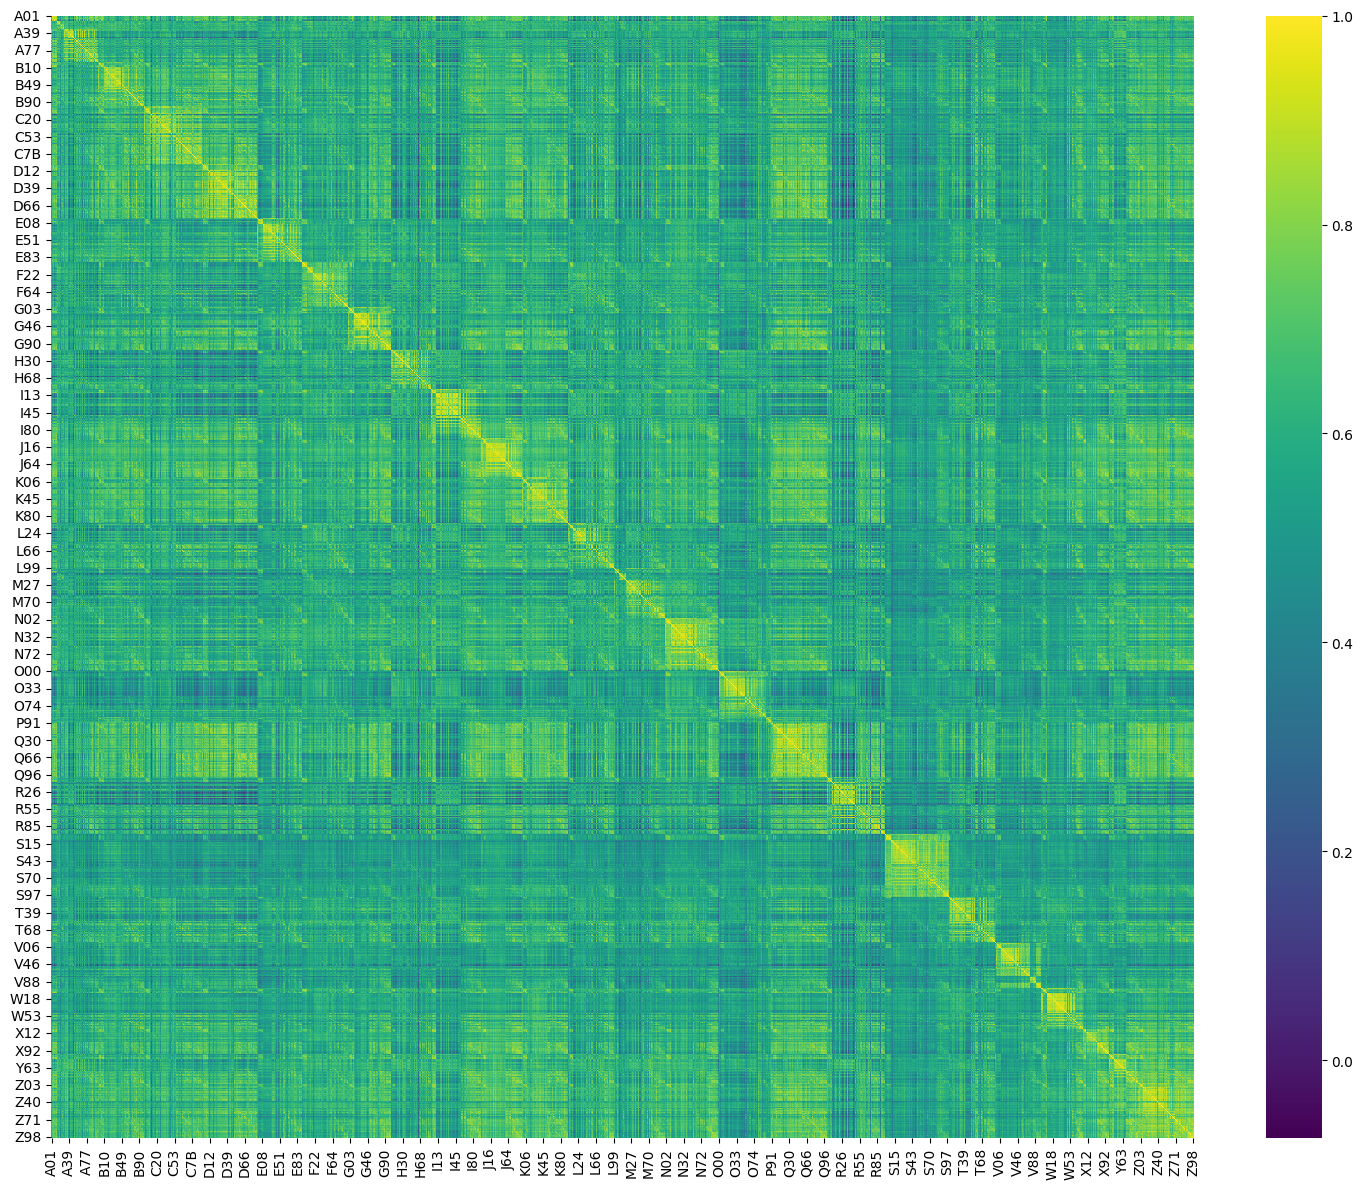

In [11]:
plt.figure(figsize=(15, 12))
sns.heatmap(similarity_scores, cmap ='viridis')
plt.tight_layout()
plt.savefig("medbert.png", dpi=100, bbox_inches='tight')
plt.show()

In [11]:
# топ пар
TOP_N = 500

long_df = similarity_scores.stack().reset_index()
long_df.columns = ['code_i', 'code_j', 'value']

long_df = long_df[long_df['code_i'] < long_df['code_j']]

top_pairs = long_df.sort_values(by='value', ascending=False).head(TOP_N)
top_pairs.to_csv(f"top_medbert.csv", index=False)
print(top_pairs.iloc[0:20])

        code_i code_j     value
838567     G31    G32  0.971930
842083     G35    G36  0.968781
840326     G32    G36  0.968719
2260790    S05    S07  0.966733
1079413    I38    I39  0.964447
1979515    Q21    Q28  0.964364
1708780    N32    N36  0.964207
1060080    I26    I33  0.963884
1995331    Q31    Q32  0.963511
341071     C58    C78  0.963160
2728417    W31    W32  0.962360
1088205    I43    I46  0.960654
2009400    Q41    Q51  0.960324
838569     G31    G36  0.960194
1088203    I43    I44  0.959920
494007     D49    D59  0.958812
1666586    N05    N07  0.958785
2703806    W17    W19  0.958595
2730175    W32    W33  0.958589
840325     G32    G35  0.958084


In [147]:
df["is_category"] = df["icd10_category"].apply(icd.is_category)
df = df[df["is_category"]]
df["parent"] = df["icd10_category"].apply(icd.get_parent)
df["chapter"] = df["parent"].apply(icd.get_parent)
df["is_chapter"] = df["chapter"].apply(icd.is_chapter)
df.loc[~df['is_chapter'], 'chapter'] = df.loc[~df['is_chapter'], 'chapter'].apply(icd.get_parent)
df["is_chapter"] = df["chapter"].apply(icd.is_chapter)
df.loc[~df['is_chapter'], 'chapter'] = df.loc[~df['is_chapter'], 'chapter'].apply(icd.get_parent)

/tmp/ipython-input-147-608329879.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["parent"] = df["icd10_category"].apply(icd.get_parent)
/tmp/ipython-input-147-608329879.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["chapter"] = df["parent"].apply(icd.get_parent)
/tmp/ipython-input-147-608329879.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

In [150]:
df["description"] = df["chapter"].apply(icd.get_description)
df = df.sort_values(by='chapter')

/tmp/ipython-input-151-2837970707.py:42: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space on the right for the legend


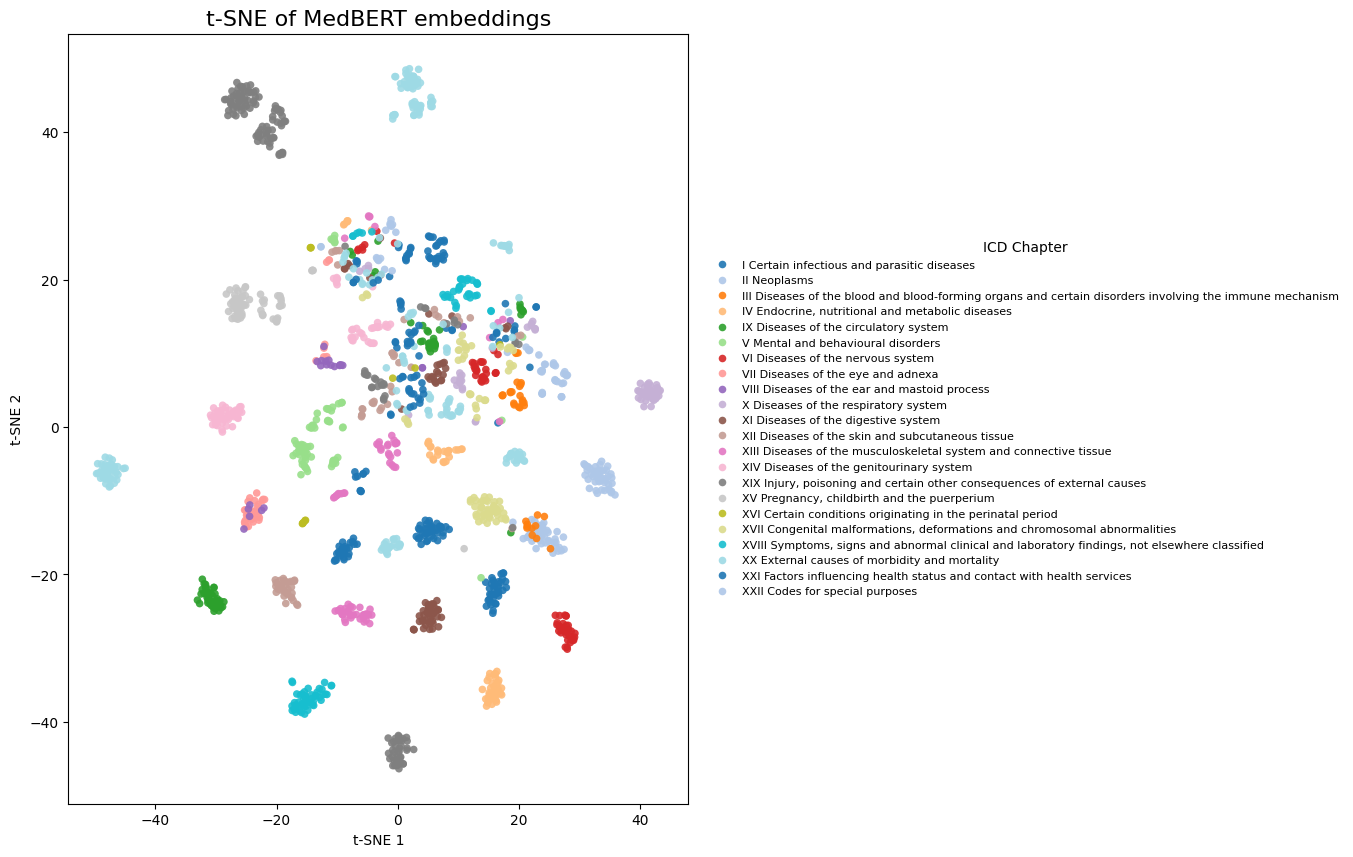

In [151]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

embeddings = np.vstack(df['cls'].values)

df['group'] = df['chapter'] + " " + df['description']

tsne = TSNE(n_components=2, random_state=42, perplexity=40,max_iter=1000)
tsne_results = tsne.fit_transform(embeddings)

df['tsne_1'] = tsne_results[:, 0]
df['tsne_2'] = tsne_results[:, 1]

plt.figure(figsize=(8, 10))
sns.scatterplot(
    x='tsne_1', y='tsne_2',
    hue='group',
    palette='tab20',
    data=df,
    s=30,
    alpha=0.9,
    linewidth=0
)

plt.title("t-SNE of MedBERT embeddings", fontsize=16)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

plt.legend(
    title="ICD Chapter",
    bbox_to_anchor=(1.02, 0.5),
    loc='center left',
    fontsize=8,
    title_fontsize='medium',
    ncol=1,
    frameon=False
)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig("medbert_tsne.png", dpi=100, bbox_inches='tight')
plt.show()